# `프로젝트 주제`

## 분류, 회귀를 활용한 기업 특성과 데이터사이언스 직군 연봉의 다층적 관계 분석 및 예측

---

## `파생주제`

급여 밴드 분류

주어진 채용 공고는 시장에서 저·중·고 어느 급여 구간에 속하는가?

▶ Random Forest Classifier + 클래스 가중치, 10-Fold CV

---

평균 급여 정량 예측

기업 특성만으로 평균 연봉(USD K$)을 얼마나 정확히 추정할 수 있는가?

▶ Random Forest Regressor, 극단치 2 % Trim, 10-Fold CV

---

급여 결정 요인 해석

Revenue, Rating, Company Age, Position Level 등 각 변수는 급여를 얼마만큼 변화시키는가?

▶ feature_importances_ + Partial Dependence / 잔차 분석

---

실무 활용 시나리오

HR: 공고를 올리기 전 예상 급여 밴드·수치 산출 → 보상 전략 조정

구직자: 현실적 기대 연봉 설정 및 기업 필터링

정책·연구: 업종·규모별 임금 격차 계량 근거 제공



---
# `프로젝트 과정`
### 전처리부터 진행

결측치는

숫자형 : 평균의 반올림값

범주형 : 최빈값

단, position_encoded 는 기존에 오디널한 범주형을 숫자로 바꾼것이므로 따라서 최빈값으로 채움.



`1. 목표 변수 설정`

분류 과제: avg_salary를 3-분위(Q1·Q2·Q3) 기준으로 Low / Mid / High 세 구간으로 나누어 SalaryBand라는 범주형 타깃을 생성하였다.

회귀 과제: avg_salary 자체를 연속형 타깃으로 사용하였다.

두 과제를 동일 파이프라인에서 다루기 위해, 데이터 누설을 유발할 수 있는 min_salary와 max_salary 피처는 훈련 입력(X_full)에서 제거하였다.

`3. 피처 구분 및 전처리`

데이터셋의 컬럼을 수치형(7 개) 과 범주형(8 개) 으로 자동 구분하였다.

수치형은 `StandardScaler()`로 평균 0·표준편차 1 표준화.

범주형은 `OneHotEncoder(handle_unknown='ignore', sparse_output=False)`로 원-핫 인코딩.

이 전처리 로직을 ColumnTransformer에 묶어, 추후 파이프라인 학습·예측 단계에서 한 번에 호출할 수 있도록 구성하였다.

`3. 분류 모델-1 : 기본 Random Forest`
`RandomForestClassifier(n_estimators = 1000, max_features = 'sqrt')`를 사용해 10-Fold Stratified CV로 기본 성능을 측정하였다.

Baseline Accuracy ≈ 0.812

Macro-F1 0.811

Confusion Matrix에서 Mid 클래스 Recall 0.770이 Low(0.81)·High(0.86)보다 낮게 확인됨.

`4. 분류 모델-2 : 클래스 가중치 실험`

| class\_weight (L : M : H) |  Accuracy |  Macro F1 | Mid Recall | 비고                     |
| ------------------------- | :-------: | :-------: | :--------: | ---------------------- |
| **1 : 1 : 1** *(기본)*      | **0.812** | **0.811** |    0.770   | 기준                     |
| 1 : 2 : 1                 |   0.808   |   0.807   |    0.770   | 정확도 −0.004, Mid 변화 0   |
| 1 : 3 : 1                 |   0.804   |   0.800   |    0.778   | 정확도 −0.008, Mid +0.008 |
| 1 : 4 : 1                 |   0.804   |   0.800   |    0.778   | 동일                     |

가중치를 2–4 배로 높여도 Mid Recall은 최대 +0.8 pp에 그쳤고 Accuracy·F1은 최대 1 pp 감소.

Trade-off(이득 < 손실) 인 점을 고려해, 가중치 없이(1 : 1 : 1) 학습한 모델을 최종 분류기로 채택하였다.

Mid 클래스 추가 향상은 Balanced Random Forest / 오버샘플링·임계값 조정 등의 후속 연구 과제로 남김.

→ 최종 “원래 가중치(1 : 1 : 1)” 유지

`6. 회귀 모델-1 : 전체 데이터, 원 타깃`

RandomForestRegressor를 대상으로 n_estimators(300·600·1000)와 max_depth(None·20)를 그리드 탐색하였다.

최적 설정 = n_estimators 300, max_features √, max_depth None

10-Fold RMSE ≈ 18.71 K, R² ≈ 0.69

`7. 회귀 모델-2 : 로그 변환 타깃`

타깃을 log1p(avg_salary) 로 변환하여 동일한 그리드를 탐색하였다.

로그-RMSE 0.204 → 역변환 RMSE ≈ 19.26 K

극단부 잔차 분산이 약간 균등해졌지만 전체 RMSE와 R²가 오히려 악화되어 채택하지 않았다.

`8. 회귀 모델-3 : 극단치(상·하위 2 %) 제거 전처리 후 재학습`

전처리: 급여 분포의 하위 2 %(≤ ≈ 30 K$)와 상위 2 %(≥ ≈ 200 K$) 샘플을 제외하여, 극단치로 인한 모델 분산을 완화하였다.

학습 알고리즘: 전처리만 달리하고, 이전과 동일한 RandomForestRegressor(n = 300, max_features = √, max_depth = None)로 10-fold CV를 수행.

결과

Trim 적용 10-Fold RMSE ≈ 15.96 K$ → 기본 전체 데이터 모델(18.71 K$) 대비 3 K$(≈ 16 %) 개선

R² ≈ 0.77 로 세 가지 회귀 실험 중 설명력이 가장 높음

따라서 ‘Trim 2 % 전처리 + Random Forest 회귀’ 조합을 최종 회귀 파이프라인으로 채택하였다.

`9. 피처 중요도 해석`

feature_importances_ 기반 막대그래프 분석 결과:

|  순위 | 분류 모델 (Gini 중요도)         | 회귀 모델 (MSE 감소 중요도)       |
| :-: | :----------------------- | :----------------------- |
|  1  | Revenue                  | Position\_Encoded        |
|  2  | Rating                   | Company\_age             |
|  3  | Company\_age             | Job Title\_Data Analysis |
|  4  | Position\_Encoded        | Revenue                  |
|  5  | Job Title\_Data Analysis | Rating                   |


재무 규모·기업 평점·회사 연령·직급·데이터 분석가/job title 이 급여 밴드 분류와 평균 급여 예측 모두에서 핵심 변인임을 확인하였다.

`10. 어려움과 해결`

| 문제(발생 단계)                          | 증상 · 분석                                                             | 시도한 접근                                                                                       | 최종 해결법 & 교훈                                                                                                                     |
| ---------------------------------- | ------------------------------------------------------------------- | -------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- |
| **A. Mid 클래스 리콜 낮음**<br>(분류 모델링)   | 기본 RF(1:1:1)에서 Mid Recall 0.770, Low·High 대비 7–9 pp 낮아 **예측 난이도 차이 확인** 확인 | 1. `class_weight` 단계 조정 → 1:2:1, 1:3:1, 1:4:1 실험 | • 가중치 3·4배까지 Mid Recall +0.8–1.0 pp vs Accuracy –0.4–0.8 pp → 비용 대비 이득 미미<br>⇒ **가중치 유지** 후 **SMOTE·임계값 조정** 등 특성 중첩 완화 전략 추진 |
| **B. 급여 분포 이분산·극단치**<br>(회귀 잔차 분석) | 원 모델 잔차가 저·고 급여 구간에서 크게 퍼짐, RMSE 18.71 K                            | 1. 로그 타깃(`log1p`) → 잔차 분산↓·RMSE 19.26 K (악화)<br>2. Box plot/IQR로 극단치 파악 → 상·하위 2% Cut(Trim)  | Trim(±2%) 적용 후 CV RMSE 18.71→15.96 K (–16%), R² 0.69→0.77 → **극단치 제거가 가장 효과적**임을 확인                                             |


단순 가중치보다는 데이터 자체(극단치, 불균형) 품질 개선이 성능 향상에 더 효과적이었다.

`11. 최종 선택 & 결론`

분류 : RandomForestClassifier (n = 1000, √, class_weight 1:2:1) – Accuracy 0.808, F1 0.807

회귀 : RandomForestRegressor (n = 300, √, Trim 2 %) – RMSE 15.96 K, R² 0.77

의미 있는 인사이트 :

매출 규모·기업 평점·회사 연령과 직급이 연봉에 가장 큰 영향

극단치 공고(상·하위 2 %)를 제외하면 모델의 평균 예측 오차가 16 % 감소


| 목적                                   | 선택 알고리즘                    | 왜 필요한가?                                                                                         | 얻어지는 실질적 가치                                                                                                          |
| ------------------------------------ | -------------------------- | ----------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------- |
| **① 급여 밴드 예측**<br>(Low / Mid / High) | **RandomForestClassifier** | - 채용 공고를 올리는 기업-입장에서 “우리 공고는 시장에서 어느 급여 구간에 속하나?”<br>- 구직자-입장에서 “지원하려는 기업이 저·중·고 중 어디에 해당하나?”   | *의사결정 지원*<br>• HR 팀이 공고를 수정해 **타깃 급여 밴드** 맞추기<br>• 구직자가 **필터링**(Low 제외 등) 할 때 활용                                     |
| **② 평균 급여 수치 예측**                    | **RandomForestRegressor**  | - 투자·연봉협상 단계에서 **정량적 기대치**(예: “95 K ± 16 K”)가 필요<br>- 회사 특성(매출·평점·연령·직급)이 **급여를 얼마나 끌어올리는가** 분석 | *정량적 가이드*<br>• 기업: 보상 정책 책정 시 **시장 대비 갭** 확인<br>• 구직자: 이직·협상 시 **합리적 목표선** 설정<br>• 정책 연구: 업종·규모별 급여 차이 **계량적 근거** 확보 |


이번 결과로 얻은 핵심 인사이트

| 분야            | 실험 결과                                                                                    | 인사이트 & 활용 방안                                                                                                                   |
| ------------- | ---------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| **분류**        | Accuracy **0.808**, Macro-F1 **0.807** (가중치 1:2:1)<br>Mid Recall 0.770 → 0.772(↑ 0.2 pp) | • 구인 공고를 올렸을 때, **80 % 정확도**로 급여 구간을 즉시 예측할 수 있음.<br>• HR 팀은 예상 급여 밴드를 확인하고 *경쟁 시장 대비 위치*를 빠르게 조정.                             |
| **회귀**        | Trim(±2 %) 모델 **RMSE 15.96 K\$**, R² 0.77                                                | • 회사가 **평균 ±16 K\$ 오차**로 예상 연봉을 산정 가능 → 예산·채용 승인에 활용.<br>• 구직자는 기업 공개 정보(매출, 평점, 연령 등)만으로 **현실적 기대 연봉**을 가늠.                   |
| **공통 피처 중요도** | Revenue, Rating, Company\_age, Position\_Encoded, Job Title\_Data Analysis 상위                                      | • **매출 규모 + 포지션**이 연봉에 가장 큰 양(+)의 영향 → HR 브랜딩·평점 관리의 중요성. |


이 모델은 분류와 회귀 두 축을 통해 ‘기업 특성→급여’ 관계를 다층적으로 탐구하였다.<br>
분류 모델은 채용 공고가 시장에서 어느 급여 밴드(저·중·고) 에 위치하는지를 80 % 이상의 정확도로 즉시 제공하여 HR 의사결정(공고 조정·입사 지원 필터링)에 활용될 수 있다.<br>
회귀 모델은 동일 특성을 바탕으로 평균 급여를 ±16 K$ 오차 내로 예측함으로써, 연봉 협상·예산 산정 시 정량적 기준점을 제시한다.<br>
두 모델에서 공통적으로 드러난 Revenue, Rating, Company Age, Position이 연봉 형성의 핵심 요인임을 시사하며, 이는 기업·구직자 모두에게 실질적인 전략 지표로 활용 가능하다.”

## 전처리

In [ ]:
import pandas as pd
import numpy as np

# 1) 데이터 불러오기
df = pd.read_csv('glassdoor_cleaned_final.csv')

# 2) 결측이 있는 컬럼 리스트 추출
missing_cols = df.columns[df.isnull().any()].tolist()

# 3) 숫자형 vs 범주형 분리
numeric_cols = df[missing_cols].select_dtypes(include=['number']).columns.tolist()
# Position_Encoded는 ordinal 범주형으로 처리하기 위해 숫자형 리스트에서 제외
numeric_cols = [col for col in numeric_cols if col != 'Position_Encoded']

categorical_cols = df[missing_cols].select_dtypes(include=['object','category']).columns.tolist()
# Position_Encoded를 범주형 처리 대상에 추가
if 'Position_Encoded' not in categorical_cols:
    categorical_cols.append('Position_Encoded')

# 4) 숫자형은 평균의 반올림 값으로 채우기
for col in numeric_cols:
    mean_val = df[col].mean()
    fill_val = int(round(mean_val))
    df[col].fillna(fill_val, inplace=True)
    print(f"Filled numeric   {col} with rounded mean={fill_val}")

# 5) 범주형은 최빈값으로 채우기
for col in categorical_cols:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)
    print(f"Filled categorical {col} with mode='{mode_val}'")

# 6) 검증: 모든 결측이 없어졌는지 확인
print("\n남은 결측치 개수:\n", df.isnull().sum())

df.to_csv('glassdoor_cleaned_final_filled.csv', index=False)
# 7) 최종 데이터 저장



[Classification] Accuracy (w/ custom weights): 0.812
Confusion Matrix:
 [[259  32  29]
 [ 41 244  32]
 [ 23  23 273]]
              precision    recall  f1-score   support

        High       0.82      0.86      0.84       319
         Low       0.80      0.81      0.81       320
         Mid       0.82      0.77      0.79       317

    accuracy                           0.81       956
   macro avg       0.81      0.81      0.81       956
weighted avg       0.81      0.81      0.81       956


[Regression] Raw target best RMSE: 18.71 {'reg__max_depth': None, 'reg__max_features': 'sqrt', 'reg__n_estimators': 300}
[Regression] Log target best log-RMSE: 0.204 {'reg__max_depth': None, 'reg__max_features': 'sqrt', 'reg__n_estimators': 300}
           ↳   RMSE (back-transform): 19.26

[Regression] RMSE after trimming 2% tails: 15.96


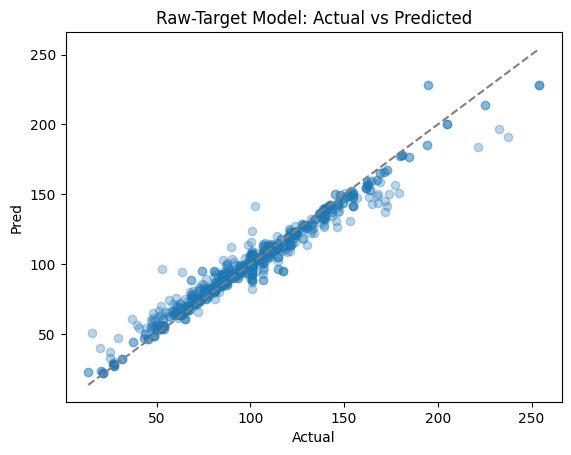

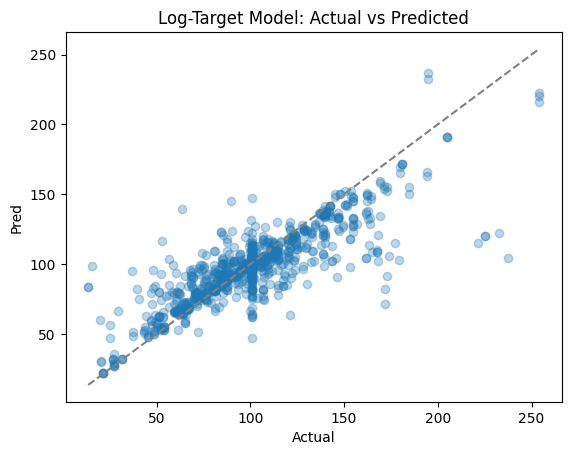

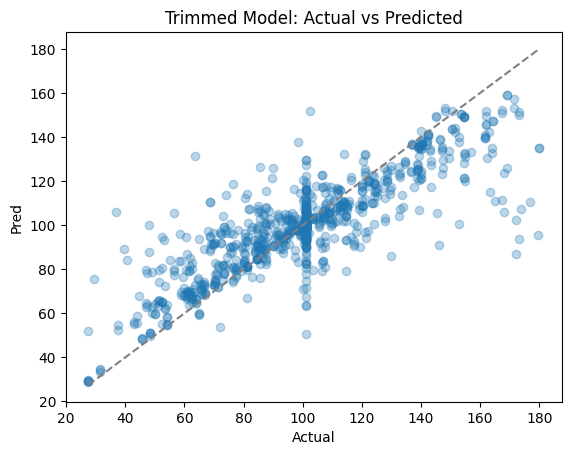

In [ ]:
# ============================================================
# 0. 기본 import & 데이터 준비
# ============================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, KFold, cross_val_predict
)
from sklearn.pipeline      import Pipeline
from sklearn.compose       import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble      import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics       import (
    accuracy_score, confusion_matrix,
    mean_squared_error, r2_score,
    classification_report
)

df = pd.read_csv('glassdoor_cleaned_final_filled.csv')
df['SalaryBand'] = pd.qcut(df['avg_salary'], q=3, labels=['Low','Mid','High'])

X_full = df.drop(columns=['min_salary','avg_salary','max_salary','SalaryBand'])
y_clf  = df['SalaryBand']
y_reg  = df['avg_salary']
y_log  = np.log1p(y_reg)               # 로그 타깃

num_cols = X_full.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_full.select_dtypes(include=['object','category','bool']).columns.tolist()

pre = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols),
])

cv10_clf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv10_reg = KFold(n_splits=10, shuffle=True, random_state=42)

# ============================================================
# 1. 분류 – 클래스 가중치 수동 조정
# ============================================================
clf_weight_pipe = Pipeline([
    ('pre', pre),
    ('clf', RandomForestClassifier(
        n_estimators=1000, max_features='sqrt',
        class_weight={'Low':1, 'Mid':1, 'High':1},   # 수동 가중
        random_state=42
    ))
])

acc = accuracy_score(
    y_clf,
    cross_val_predict(clf_weight_pipe, X_full, y_clf, cv=cv10_clf)
)
cm  = confusion_matrix(
    y_clf,
    cross_val_predict(clf_weight_pipe, X_full, y_clf, cv=cv10_clf),
    labels=['Low','Mid','High']
)
print("\n[Classification] Accuracy (w/ custom weights):", round(acc, 3))
print("Confusion Matrix:\n", cm)
print(classification_report(y_clf, cross_val_predict(clf_weight_pipe, X_full, y_clf, cv=cv10_clf)))
# ============================================================
# 2. 회귀 – 원 타깃 vs. 로그 타깃, 하이퍼파라미터 Grid 확장
# ============================================================
reg_pipe = Pipeline([
    ('pre', pre),
    ('reg', RandomForestRegressor(random_state=42))
])
reg_grid = {
    'reg__n_estimators': [300, 600, 1000],
    'reg__max_depth'   : [None, 20],
    'reg__max_features': ['sqrt', 0.6],
}

# (a) 원 타깃
gs_raw = GridSearchCV(reg_pipe, reg_grid, cv=cv10_reg,
                      scoring='neg_root_mean_squared_error', n_jobs=-1)
gs_raw.fit(X_full, y_reg)
rmse_raw = -gs_raw.best_score_
print("\n[Regression] Raw target best RMSE:", rmse_raw.round(2),
      gs_raw.best_params_)

# (b) 로그 타깃
gs_log = GridSearchCV(reg_pipe, reg_grid, cv=cv10_reg,
                      scoring='neg_root_mean_squared_error', n_jobs=-1)
gs_log.fit(X_full, y_log)
rmse_log = -gs_log.best_score_
print("[Regression] Log target best log-RMSE:", rmse_log.round(3),
      gs_log.best_params_)

# 로그 모델을 역변환해 실제 RMSE 환산
y_pred_log = np.expm1(
    cross_val_predict(gs_log.best_estimator_, X_full, y_log, cv=cv10_reg)
)
# ▶ 수정: MSE 계산 후 sqrt
mse_log_back  = mean_squared_error(y_reg, y_pred_log)
rmse_log_back = np.sqrt(mse_log_back)
print("           ↳   RMSE (back-transform):", round(rmse_log_back, 2))

# ============================================================
# 3. 회귀 – 극단치(outlier) 제거 후 재학습
#     (상·하위 2% 컷 기준; 필요 시 다른 임계값으로 수정)
# ============================================================
low_q, high_q = y_reg.quantile([0.02, 0.98])
mask = (y_reg >= low_q) & (y_reg <= high_q)

X_trim = X_full.loc[mask]
y_trim = y_reg.loc[mask]

trim_pipe = Pipeline([
    ('pre', pre),
    ('reg', RandomForestRegressor(
        n_estimators=gs_raw.best_params_['reg__n_estimators'],
        max_depth   =gs_raw.best_params_['reg__max_depth'],
        max_features=gs_raw.best_params_['reg__max_features'],
        random_state=42))
])

mse_trim = mean_squared_error(
    y_trim,
    cross_val_predict(trim_pipe, X_trim, y_trim, cv=cv10_reg)
)
rmse_trim = np.sqrt(mse_trim)
print("\n[Regression] RMSE after trimming 2% tails:", rmse_trim.round(2))

# ============================================================
# 4. (선택) 잔차 플롯 비교
# ============================================================
plt.figure()
plt.scatter(y_reg, gs_raw.best_estimator_.predict(X_full), alpha=0.3)
plt.title('Raw-Target Model: Actual vs Predicted'); plt.xlabel('Actual'); plt.ylabel('Pred')
plt.plot([y_reg.min(), y_reg.max()],[y_reg.min(), y_reg.max()],'--',c='gray')

plt.figure()
plt.scatter(y_reg, y_pred_log, alpha=0.3)
plt.title('Log-Target Model: Actual vs Predicted'); plt.xlabel('Actual'); plt.ylabel('Pred')
plt.plot([y_reg.min(), y_reg.max()],[y_reg.min(), y_reg.max()],'--',c='gray')

plt.figure()
plt.scatter(y_trim, cross_val_predict(trim_pipe, X_trim, y_trim, cv=cv10_reg), alpha=0.3)
plt.title('Trimmed Model: Actual vs Predicted'); plt.xlabel('Actual'); plt.ylabel('Pred')
plt.plot([y_trim.min(), y_trim.max()],[y_trim.min(), y_trim.max()],'--',c='gray')
plt.show()


In [ ]:
# ============================================================
# 1. 분류 – 클래스 가중치 수동 조정
# ============================================================
clf_weight_pipe = Pipeline([
    ('pre', pre),
    ('clf', RandomForestClassifier(
        n_estimators=1000, max_features='sqrt',
        class_weight={'Low':1, 'Mid':2, 'High':1},   #  수동 가중
        random_state=42
    ))
])

acc = accuracy_score(
    y_clf,
    cross_val_predict(clf_weight_pipe, X_full, y_clf, cv=cv10_clf)
)
cm  = confusion_matrix(
    y_clf,
    cross_val_predict(clf_weight_pipe, X_full, y_clf, cv=cv10_clf),
    labels=['Low','Mid','High']
)
print("\n[Classification] Accuracy (w/ custom weights):", round(acc, 3))
print("Confusion Matrix:\n", cm)
print(classification_report(y_clf, cross_val_predict(clf_weight_pipe, X_full, y_clf, cv=cv10_clf)))

NameError: name 'Pipeline' is not defined

In [ ]:
# ============================================================
# 1. 분류 – 클래스 가중치 수동 조정
# ============================================================
clf_weight_pipe = Pipeline([
    ('pre', pre),
    ('clf', RandomForestClassifier(
        n_estimators=1000, max_features='sqrt',
        class_weight={'Low':1, 'Mid':3, 'High':1},   # 수동 가중
        random_state=42
    ))
])

acc = accuracy_score(
    y_clf,
    cross_val_predict(clf_weight_pipe, X_full, y_clf, cv=cv10_clf)
)
cm  = confusion_matrix(
    y_clf,
    cross_val_predict(clf_weight_pipe, X_full, y_clf, cv=cv10_clf),
    labels=['Low','Mid','High']
)
print("\n[Classification] Accuracy (w/ custom weights):", round(acc, 3))
print("Confusion Matrix:\n", cm)
print(classification_report(y_clf, cross_val_predict(clf_weight_pipe, X_full, y_clf, cv=cv10_clf)))


[Classification] Accuracy (w/ custom weights): 0.804
Confusion Matrix:
 [[253  39  28]
 [ 36 246  35]
 [ 23  26 270]]
              precision    recall  f1-score   support

        High       0.81      0.85      0.83       319
         Low       0.81      0.79      0.80       320
         Mid       0.79      0.78      0.78       317

    accuracy                           0.80       956
   macro avg       0.80      0.80      0.80       956
weighted avg       0.80      0.80      0.80       956




=== Top-10 Feature Importances – Classifier ===


Revenue                        0.101989
Rating                         0.095649
Company_age                    0.095461
Position_Encoded               0.072271
Job Title_Data Analysis        0.040462
Job Title_Data Science         0.040288
Location_state_binned_Other    0.020764
Job Title_Data Engineering     0.019078
works_at_headquarters_No       0.018749
works_at_headquarters_Yes      0.018242
dtype: float64


=== Top-10 Feature Importances – Regressor (Trim 모델) ===


Position_Encoded                0.100333
Company_age                     0.083643
Job Title_Data Analysis         0.081592
Revenue                         0.077708
Rating                          0.073872
Job Title_Data Science          0.059857
Location_state_binned_Other     0.024444
Location_state_binned_ca        0.023014
Ownership_Grouped_Public        0.018639
Job Title_Medical/Healthcare    0.017235
dtype: float64

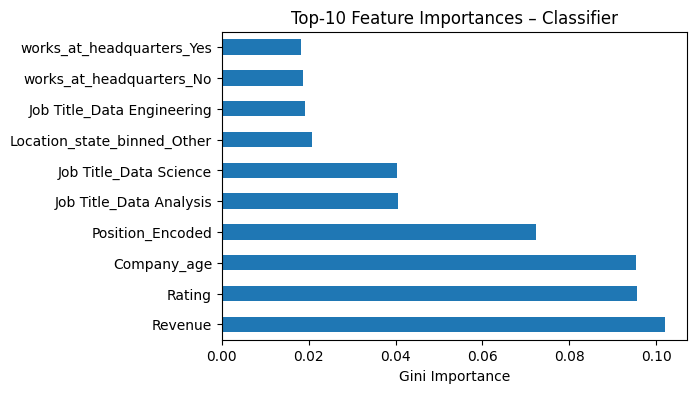

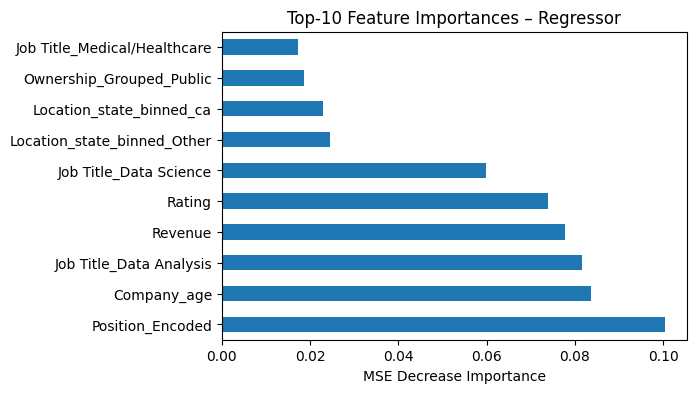

In [ ]:
# 5-1) 분류기 파이프라인 전체 데이터로 최종 적합
clf_weight_pipe.fit(X_full, y_clf)

# 5-2) 회귀 파이프라인 Trim(±2 %) 데이터로 최종 적합
trim_pipe.fit(X_trim, y_trim)

# 5-3) 전처리기에 들어간 최종 feature 이름 추출
preproc = clf_weight_pipe.named_steps['pre']        # 두 파이프라인 공통
num_names = preproc.transformers_[0][2]             # numeric feature list
cat_names = preproc.named_transformers_['cat']\
                    .get_feature_names_out(preproc.transformers_[1][2])
feature_names = list(num_names) + list(cat_names)

# 5-4) importance 값 가져오기
fi_clf = clf_weight_pipe.named_steps['clf'].feature_importances_
fi_reg = trim_pipe.named_steps['reg'].feature_importances_

# 5-5) Top-10 시리즈 생성
import pandas as pd
top10_clf = (pd.Series(fi_clf, index=feature_names)
               .sort_values(ascending=False)
               .head(10))
top10_reg = (pd.Series(fi_reg, index=feature_names)
               .sort_values(ascending=False)
               .head(10))

print("\n=== Top-10 Feature Importances – Classifier ===")
display(top10_clf)

print("\n=== Top-10 Feature Importances – Regressor (Trim 모델) ===")
display(top10_reg)

# 5-6) 막대그래프 시각화
plt.figure(figsize=(6,4))
top10_clf.sort_values().plot.barh()
plt.title('Top-10 Feature Importances – Classifier')
plt.xlabel('Gini Importance')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(6,4))
top10_reg.sort_values().plot.barh()
plt.title('Top-10 Feature Importances – Regressor')
plt.xlabel('MSE Decrease Importance')
plt.gca().invert_yaxis()
plt.show()